# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)


## Introduction: Business Problem <a name="introduction"></a>

Every year or a few times a year almost all people have the same problem and the same dream. All the life people wait for vacation for rest and for relax. And the best way to relax is to go to the sea. All of us, at least once in a lifetime, dream about lying on the beautiful beach under the sun. Thus, every time we decide to go to sea, we have a problem with the choice of country and city.  
As a rule, we want to go to a new place, to watch and try something new, but we don’t know where our rest would be the best and would not cost so expensive. If you decide to travel to the Europe, one of the most popular sea country is Spain. Summer resorts and beaches were the first to be developed in Spain, and today, generate the most income for the Spanish economy. The mild climate during the whole year and the extensive sandy beaches of the Mediterranean and Atlantic Ocean as well as of its two archipelagoes have been attracting tourists from all of the world.
The most popular Spanish mainland coasts are on its Mediterranean side. There are two most visitable beach sides - Costa Brava and Costa Daurada, which are not so far from Barcelona. But for this work I want to explore Costa Brava. I’ll get 11 popular towns in this area and provide clustering of each of these towns to specify which town is the most suitable for different people and their needs.

There are a lot of websites and videos with information about these towns, but often it is only general description without information about accommodation, stores, beaches and other facilities. And there is a problem to choose the most appropriate town, that can satisfy your needs and possibilities. This project aims to describe three similar sea towns in Spain and which town would be suitable for different needs.


## Data <a name="data"></a>

To solve this problem I will use the Foursquare location data. Foursquare is the most trusted, independent location data platform for understanding how people move through the real world. With Places Database, I can access precise, up-to-date community-sourced venue data. To gain my purpose I need data for "Palamos", "Calella de Palafrugell", "Llafranc", "Tamariu", "Pals","Begur", "Cadaques", "Lloret de Mar", "Tossa de Mar", "Blanes", "l'Escala". In every city I will explore their hotels, apartments, restaurants, cafes, groceries, markets, beaches, bus stations, train station, parks, night life, playgrounds. I separately got all categories that I need for my exploration and joined into one table.

#### Fist, let's import all necessary library for my exploration. 

In [9]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

import folium # plotting library

# import k-means from clustering stage
from sklearn.cluster import KMeans

# import matplotlib
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

print('Libraries imported.')

Libraries imported.


#### Next, write town's names to the list. 

In [10]:
cities = ["Palamos", "Calella de Palafrugell", "Llafranc", "Tamariu", "Pals","Begur", "Cadaques", "Lloret de Mar", "Tossa de Mar", "Blanes", "l'Escala"]
cities

['Palamos',
 'Calella de Palafrugell',
 'Llafranc',
 'Tamariu',
 'Pals',
 'Begur',
 'Cadaques',
 'Lloret de Mar',
 'Tossa de Mar',
 'Blanes',
 "l'Escala"]

In [11]:
CLIENT_ID = 'VBIFUSZ1E0GYG0HXKB3NVLBY3IODFCCJKCRMJBGX0VN5QXQN' # my Foursquare ID
CLIENT_SECRET = 'ARVMYNBGADWJ1NDS2CTPHXSKEJOIRCM3ZUB4ISQ3TUE4FJ1G' # my Foursquare Secret
VERSION = '20200227'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: VBIFUSZ1E0GYG0HXKB3NVLBY3IODFCCJKCRMJBGX0VN5QXQN
CLIENT_SECRET:ARVMYNBGADWJ1NDS2CTPHXSKEJOIRCM3ZUB4ISQ3TUE4FJ1G


#### I got data about venues for each of these cities in radius 2000 m.
#### And I have chosen such categories and get their Id from Forsquare: 
1. Hotel 

2. Food

3. Food&Drink Shop

4. Bus Stop 

5. Bus Station

6. Train Station

7. Nightlife

8. Outdoors&Recreation

9. Arts&Entertainment  


In [12]:
#radius
radius = 2000
#list of Id of category in Foursquare
categories_ID = {'Hotel':'4bf58dd8d48988d1fa931735','Food':'4d4b7105d754a06374d81259' , 'Food_Drink_Shop':'4bf58dd8d48988d1f9941735',
                 'Bus_Stop':'52f2ab2ebcbc57f1066b8b4f','Bus Station': '4bf58dd8d48988d1fe931735', 'Train_Station': '4bf58dd8d48988d129951735',
                'Nightlife':'4d4b7105d754a06376d81259', 'Outdoors_Recreation':'4d4b7105d754a06377d81259','Arts_Entertainment':'4d4b7104d754a06370d81259' }

categories_ID

{'Hotel': '4bf58dd8d48988d1fa931735',
 'Food': '4d4b7105d754a06374d81259',
 'Food_Drink_Shop': '4bf58dd8d48988d1f9941735',
 'Bus_Stop': '52f2ab2ebcbc57f1066b8b4f',
 'Bus Station': '4bf58dd8d48988d1fe931735',
 'Train_Station': '4bf58dd8d48988d129951735',
 'Nightlife': '4d4b7105d754a06376d81259',
 'Outdoors_Recreation': '4d4b7105d754a06377d81259',
 'Arts_Entertainment': '4d4b7104d754a06370d81259'}

 Now, let's specify function to get all information about vanues for one city in defined categories. First, create url, make request and normalize JSON. I stored it into dataframe and have such columns: 'id', 'name', 'categories', 'referralId', 'hasPerk', 'location.address', 'location.lat', 'location.lng', 'location.labeledLatLngs', 'location.distance', 'location.postalCode', 'location.cc,  'location.city', 'location.state', 'location.country', 'location.formattedAddress', 'location.crossStreet', 'venuePage.id'. Then append datafreames into list. To each dataframe add new column with name of main categories. At the end, convert list into one table and return it with latitude and longitude.

In [13]:
def get_data(search_query):
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(search_query)
    print(search_query)
    latitude = location.latitude
    longitude = location.longitude
    
    frames = []
    for name, category in categories_ID.items():
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}&categoryId={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT,category)
        results = requests.get(url).json()
        # assign relevant part of JSON to venues
        venues = results['response']['venues']
        # tranform venues into a dataframe
        if(venues!=[]):
            df = json_normalize(venues)
            # add column with main category of vanue
            df['location.main_category'] = name
            #append dataframe of town to list
            frames.append(df)
            
    #concat all frames of venues into one table    
    dataframe = pd.concat(frames, sort=False)
    return dataframe, latitude, longitude

Create function that extracts the category of the venue.

In [14]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### Data cleaning & Feature selection

Function that execute all necessary data cleaning and filering. Keep only columns that include venue name, and anything that is associated with location. Filter the category for each row, clean column names by keeping only last term, replace all NuN value in the column 'city' by city name, replace all incorrect name of city by actual name, drop unnessecary columns("postalCode", "cc", "crossStreet", "state", "country", "labeledLatLngs", "distance", "address"). Some rows can have None value in column “categories”, so I have to delete them first. Because for my exploration it is the main field and it can not be None. Also, some data have NaN value in another columns, but it don’t have influence on my research and I can leave such rows in tables. 

In [15]:
def feature_selection(dataframe, city):
    # keep only columns that include venue name, and anything that is associated with location
    filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
    dataframe_filtered = dataframe.loc[:, filtered_columns]

    # filter the category for each row
    dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

    # clean column names by keeping only last term
    dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]
    
    # replace all NuN value in the column city by city name
    dataframe_filtered['city'].fillna(city, inplace = True)
    
    # replace all incorrect name of city by actually name
    dataframe_filtered.city.replace(dataframe_filtered.loc[dataframe_filtered['city']!= city].city, city, inplace = True)
    
    # drop unnessecary columns
    dataframe_filtered = dataframe_filtered.drop(["postalCode", "cc", "crossStreet", "state", "country", "labeledLatLngs", "distance", "address"], axis=1, errors='ignore')
    
    # drop city category from list 
    dataframe_filtered = dataframe_filtered[dataframe_filtered.categories != 'City']
    
    # delete None value from categories column
    dataframe_filtered.dropna(subset=['categories'])

    return dataframe_filtered

Create function to get venues for all specified towns and make data cleaning and filtering. After that concat all tables into one data frame. Also append all coordinates to one list.

In [16]:
#list of filtered tables
tables = []
#list of coordinates of cities
coords = []
def get_cities_venues():
    for city in cities:
        dataframe, lat, lng = get_data(city)
        dataframe_filtered =  feature_selection(dataframe, city)
        print(dataframe_filtered.shape)
        tables.append(dataframe_filtered)
        coords.append((lat, lng))
    data = pd.concat(tables, sort=False)
    return data

In [17]:
data = get_cities_venues()

Palamos
(64, 8)
Calella de Palafrugell
(17, 8)
Llafranc
(29, 8)
Tamariu
(22, 8)
Pals
(16, 8)
Begur
(44, 8)
Cadaques
(45, 8)
Lloret de Mar
(89, 8)
Tossa de Mar
(61, 8)
Blanes
(85, 8)
l'Escala
(102, 8)


We have dataframe with such columns: name, 	categories, 	lat, 	lng, 	formattedAddress, 	address, 	city, 	main_category, 	id. 

In all 574 rows and 8 columns. 

In [18]:
data

,name,categories,lat,lng,formattedAddress,city,main_category,id
0,Apartaments Palamos-Muntaner,Resort,41.853605,3.125373,[España],Palamos,Hotel,50145daae4b0649cc1f04107
1,Apartahotel Palamos,Hotel,41.850199,3.121722,[España],Palamos,Hotel,4e2bdd9518a80bb0585e34f9
2,Trias Hotel,Hotel,41.847977,3.126460,"[Passeig del Mar, s/n, 17230 Palamós Cataluña,...",Palamos,Hotel,4bd5aaf39649ce72f77c511d
0,El Canó de Palamós,Café,41.846417,3.129282,"[Major, Palamós Cataluña, España]",Palamos,Food,4ff698a6e4b024f559ad227b
1,Pastisseria Gloria Palamos,Dessert Shop,41.848772,3.128126,[España],Palamos,Food,50327d9ae4b0c5661e58c014
...,...,...,...,...,...,...,...,...
10,Lluna Parc,Theme Park,42.116287,3.135759,[España],l'Escala,Arts_Entertainment,5033e82ae4b05dcb2d2af997
11,La Roca Del Frare,Historic Site,42.122645,3.137693,[España],l'Escala,Arts_Entertainment,502e825de4b0f8a0004ca9aa
12,La Mar D'en Manassa,General Entertainment,42.127127,3.130864,[España],l'Escala,Arts_Entertainment,50202aace4b0dabb17b13ad0
13,Dolmen La Talaia,Historic Site,42.122932,3.132093,[España],l'Escala,Arts_Entertainment,51581199e4b0210cd89f2faa


Now, create function to visualize map for one town with its venues.

In [19]:
# create map of town using latitude and longitude values
def map_venues(latitude, longitude, dataframe):
    map_venues = folium.Map(location=[latitude, longitude], zoom_start=14.3)

# add markers to map
    for lat, lng, label in zip(dataframe['lat'], dataframe['lng'], dataframe['name']):
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_venues)  
    return map_venues

### Map for Palamos

In [20]:
map_venues(coords[0][0], coords[0][1], tables[0])

![title](img/proj/palamos.png)

### Map for Calella de Palafrugell

In [21]:
map_venues(coords[1][0], coords[1][1], tables[1])

![title](img/proj/callela.png)

### Map for Llafranc

In [22]:
map_venues(coords[2][0], coords[2][1], tables[2])

![title](img/proj/llafranc.png)

### Map for Tamariu

In [23]:
map_venues(coords[3][0], coords[3][1], tables[3])

![title](img/proj/tamariu.png)

### Map for Pals

Pals is not so close to the sea. 

In [24]:
map_venues(coords[4][0], coords[4][1], tables[4])

![title](img/proj/pals.png)

### Map for Begur

Begur also is not close to the beaches. 

In [25]:
map_venues(coords[5][0], coords[5][1], tables[5])

![title](img/proj/Begur.png)

### Map for Cadaques

In [26]:
map_venues(coords[6][0], coords[6][1], tables[6])

![title](img/proj/Cadaques.png)

### Map for Lloret de Mar

In [27]:

map_venues(coords[7][0], coords[7][1], tables[7])

![title](img/proj/lloret.png)

### Map for Tossa de Mar

In [28]:
map_venues(coords[8][0], coords[8][1], tables[8])

![title](img/proj/Tossa.png)

### Map for Blanes

In [29]:
map_venues(coords[9][0], coords[9][1], tables[9])

![title](img/proj/blanes.png)

### Map for l'Escala

In [30]:
map_venues(coords[10][0], coords[10][1], tables[10])

![title](img/proj/lescada.jpg)

## Methodology <a name="methodology"></a>

In this project we will direct our efforts on exploration sea cities of Costa Brava side, particularly specify where is better to travel. We will limit our analysis to area ~2km around city center.

In first step when we have all the required data we make data preparation for next analysis.

Second step in our analysis will be clustering of our 11 sea towns of Spain to define groups by specified categories.

In third and final step we will focus on clusters, where there are the most venues in our categories. Then we will exloplore towns separately in chosen clusters and compare them to make decision and conclusion about the best town for vacation.  


## Analysis <a name="analysis"></a>

#### Data Preparation

Before clustering let's make data preparation. First we make dummies for column **"categories"** and add column **"city"** and move it to the first column. As a result we have table with 574 rows and 139 columns.

In [31]:
# one hot encoding
venue_onehot = pd.get_dummies(data[['categories']], prefix="", prefix_sep="")

# add city column back to dataframe
venue_onehot['city'] = data['city'] 

# move city column to the first column
fixed_columns = [venue_onehot.columns[-1]] + list(venue_onehot.columns[:-1])
venue_onehot = venue_onehot[fixed_columns]

venue_onehot

,city,American Restaurant,Aquarium,Arcade,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Bakery,Bar,...,Trail,Train,Train Station,Turkish Restaurant,Vacation Rental,Village,Vineyard,Volleyball Court,Water Park,Wine Shop
0,Palamos,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Palamos,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Palamos,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,Palamos,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Palamos,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,l'Escala,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,l'Escala,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,l'Escala,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,l'Escala,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next let's group table by cities and get mean value.

In [32]:
#group venues by cities
venue_grouped = venue_onehot.groupby('city').mean().reset_index()
venue_grouped

,city,American Restaurant,Aquarium,Arcade,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Bakery,Bar,...,Trail,Train,Train Station,Turkish Restaurant,Vacation Rental,Village,Vineyard,Volleyball Court,Water Park,Wine Shop
0,Begur,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.022727,0.000000,0.000000,0.000000
1,Blanes,0.011765,0.000000,0.00000,0.000000,0.000000,0.023529,0.000000,0.000000,0.023529,...,0.000000,0.0000,0.011765,0.000000,0.011765,0.000000,0.000000,0.000000,0.011765,0.000000
2,Cadaques,0.000000,0.000000,0.00000,0.000000,0.022222,0.022222,0.000000,0.000000,0.044444,...,0.000000,0.0000,0.000000,0.000000,0.022222,0.000000,0.000000,0.000000,0.000000,0.000000
3,Calella de Palafrugell,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.058824,0.0000,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000
4,Llafranc,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.068966,0.000000,...,0.034483,0.0000,0.000000,0.000000,0.034483,0.068966,0.000000,0.000000,0.000000,0.000000
5,Lloret de Mar,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011236,...,0.011236,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Palamos,0.000000,0.000000,0.03125,0.000000,0.000000,0.000000,0.031250,0.015625,0.015625,...,0.015625,0.0000,0.000000,0.000000,0.000000,0.015625,0.000000,0.000000,0.000000,0.000000
7,Pals,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,...,0.000000,0.0625,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Tamariu,0.000000,0.045455,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.045455,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045455,0.000000
9,Tossa de Mar,0.000000,0.000000,0.00000,0.016393,0.000000,0.000000,0.016393,0.000000,0.000000,...,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016393,0.000000,0.000000


## K-means Clustering

And now we are prepared for clustering. We will use K-means clustering.

Choose number of clusters - **5**.
Drop column "city" for fitting clustering. Run clustering with random state = 0 and check cluster labels generated for each row in the dataframe.

In [33]:
# set number of clusters
kclusters = 5

venue_grouped_clustering = venue_grouped.drop('city', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venue_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 0, 1, 4, 1, 1, 0, 2, 3, 1, 0], dtype=int32)

After that add received clustering labels to venues in general dataframe. 

In [34]:
# add clustering labels to table
for i in range(len(venue_grouped)):
    data.loc[data['city'] == venue_grouped['city'][i],'Cluster Labels'] = kmeans.labels_[i]
    
    

In [35]:
data = data.astype({'Cluster Labels': 'int32'})

In [36]:
data

,name,categories,lat,lng,formattedAddress,city,main_category,id,Cluster Labels
0,Apartaments Palamos-Muntaner,Resort,41.853605,3.125373,[España],Palamos,Hotel,50145daae4b0649cc1f04107,0
1,Apartahotel Palamos,Hotel,41.850199,3.121722,[España],Palamos,Hotel,4e2bdd9518a80bb0585e34f9,0
2,Trias Hotel,Hotel,41.847977,3.126460,"[Passeig del Mar, s/n, 17230 Palamós Cataluña,...",Palamos,Hotel,4bd5aaf39649ce72f77c511d,0
0,El Canó de Palamós,Café,41.846417,3.129282,"[Major, Palamós Cataluña, España]",Palamos,Food,4ff698a6e4b024f559ad227b,0
1,Pastisseria Gloria Palamos,Dessert Shop,41.848772,3.128126,[España],Palamos,Food,50327d9ae4b0c5661e58c014,0
...,...,...,...,...,...,...,...,...,...
10,Lluna Parc,Theme Park,42.116287,3.135759,[España],l'Escala,Arts_Entertainment,5033e82ae4b05dcb2d2af997,0
11,La Roca Del Frare,Historic Site,42.122645,3.137693,[España],l'Escala,Arts_Entertainment,502e825de4b0f8a0004ca9aa,0
12,La Mar D'en Manassa,General Entertainment,42.127127,3.130864,[España],l'Escala,Arts_Entertainment,50202aace4b0dabb17b13ad0,0
13,Dolmen La Talaia,Historic Site,42.122932,3.132093,[España],l'Escala,Arts_Entertainment,51581199e4b0210cd89f2faa,0


#### Let's visulize map with clusters.

In [37]:
# create map for clusters
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode('Costa Brava')
latitude = location.latitude
longitude = location.longitude
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, categ in zip(data['lat'], data['lng'], data['name'], data['Cluster Labels'], data['categories']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + ' Category ' + str(categ), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

So, now let's analyze our result of clustering and make some conclusions.

Define function, that plot bars for our five clusters with amount of specific main categories.

As we can see, **Palamos**, **Blanes** and **l'Escala** are in the first cluster and have a lot of outdoor recreations, food, more night life, more food shops and only this cluster has Train station. 

Llafranc, Begur, Cadaques, Lloret de Mar, and Tossa de Mar are in the second cluster, where there are more Hotels, Food, outdoor recreations and bus stations. 

Other tree towns: Pals, Tamariu, and Calella de Palafrugell are the other three clusters. These clusters have very little amount of venues comparing with first two clusters. 

So let's explore only cities that first and second cluster contain. 

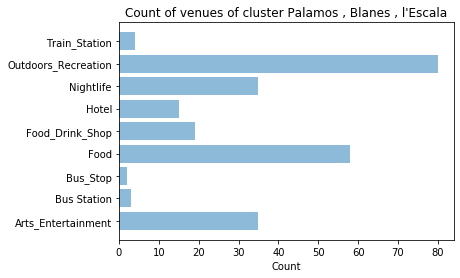

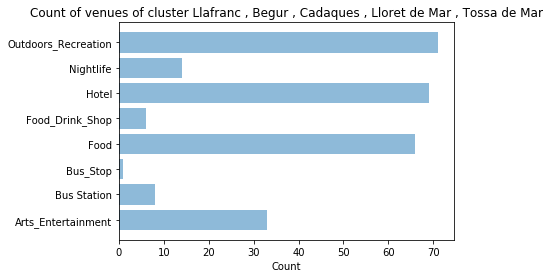

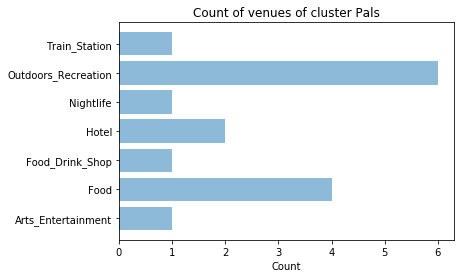

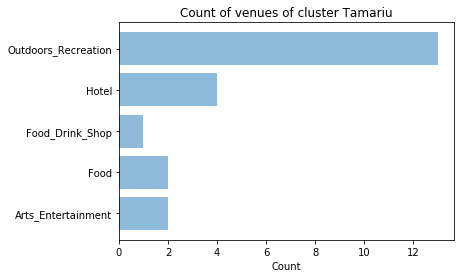

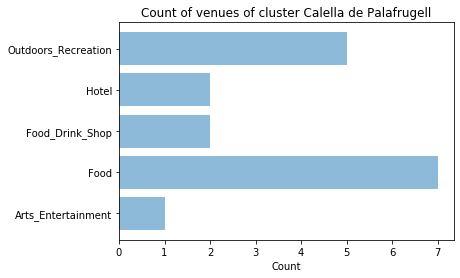

In [38]:
#plot bars for all 5 clusters with their main categories 
def plot_bar(categories, count, cities):
    y_pos = np.arange(len(categories))
    plt.barh(y_pos, count, align='center', alpha=0.5)
    plt.yticks(y_pos, categories)
    plt.xlabel('Count')
    plt.title('Count of venues of cluster ' + cities)
    plt.show()
    
for i in range(5):
    countcateg = data.loc[data['Cluster Labels'] == i].groupby('main_category').count().reset_index()
    cities = ' , '.join(data.loc[data['Cluster Labels'] == i]['city'].unique().tolist())
    plot_bar(countcateg['main_category'], countcateg['city'], cities)

Get first cluster with Palamos, Blanes, and l'Escala and plot bars with main categories for each city separatly.
In all three cities we have almost the same number of Recreations and Outdors approximately **25**.

About 15 night life. In Palamos and Blanes 15 food places and in l'Escala 30 such places. There are not so much hotels - around 5 in each. Only in Blanes are 5 Train stations. 

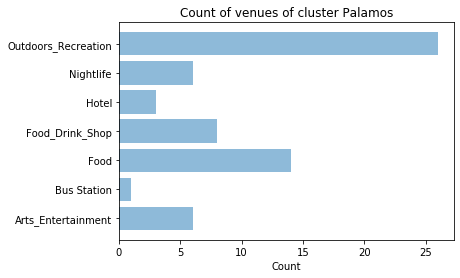

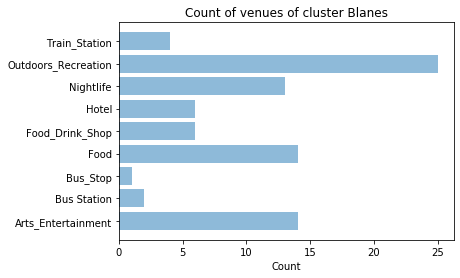

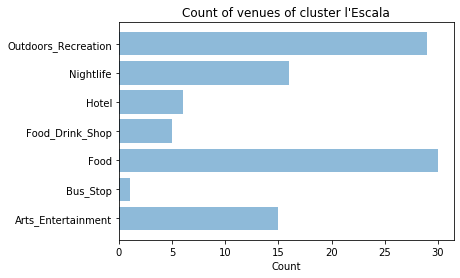

In [39]:
#Get first cluster and plot bars for each city in this cluster
cities = data.loc[data['Cluster Labels'] == 0]['city'].unique().tolist() 
first_cluster = data.loc[data['Cluster Labels'] == 0]

for i in range(len(cities)):
    df = first_cluster.loc[first_cluster['city'] == cities[i]].groupby('main_category').count().reset_index()
    y_pos = np.arange(len(df['main_category']))
    plt.barh(y_pos, df['city'], align='center', alpha=0.5)
    plt.yticks(y_pos, df['main_category'])
    plt.xlabel('Count')
    plt.title('Count of venues of cluster ' + cities[i])
    plt.show()

Get second cluster with Llafranc, Begur, Cadaques, Lloret de Mar, and Tossa de Mar and plot bars with main categories for each city separatly. In Llafranc and Begur are not a lot of venues, so we can stop explore these two towns. Cadaques has foods, outdoors recreation and hotels, but Lloret de Mar has much more hotels(around 30). In Tossa de Mar are a lot of oudoors recreations. 

But now we want to have diagram with all of these towns to have possibility compare them among main categories.

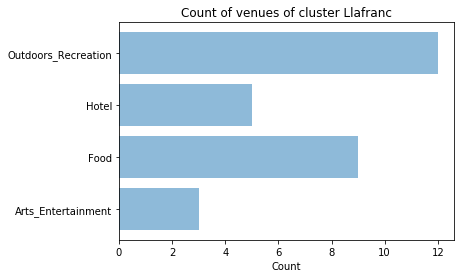

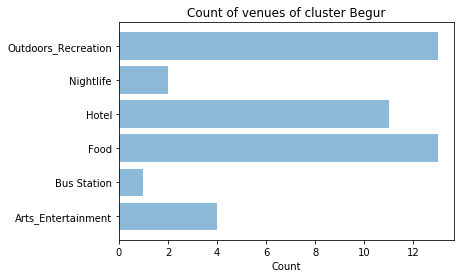

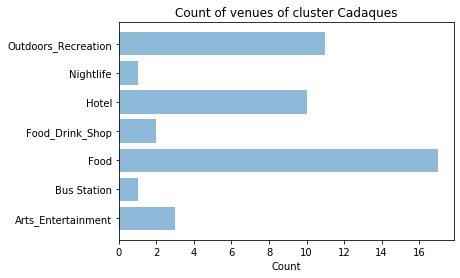

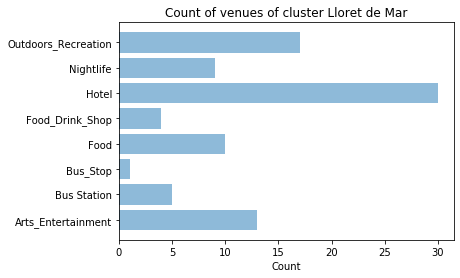

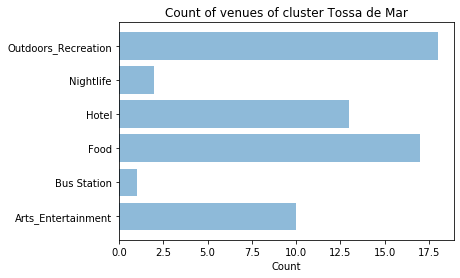

In [40]:
#Get second cluster and plot bars for each city in this cluster
cities = data.loc[data['Cluster Labels'] == 1]['city'].unique().tolist()
first_cluster = data.loc[data['Cluster Labels'] == 1]

for i in range(len(cities)):
    df = first_cluster.loc[first_cluster['city'] == cities[i]].groupby('main_category').count().reset_index()
    y_pos = np.arange(len(df['main_category']))
    plt.barh(y_pos, df['city'], align='center', alpha=0.5)
    plt.yticks(y_pos, df['main_category'])
    plt.xlabel('Count')
    plt.title('Count of venues of cluster ' + cities[i])
    plt.show()

For this purpose, write chosen towns to the list.

In [41]:
cit = ['Blanes', 'Tossa de Mar', 'Lloret de Mar', "l'Escala", 'Palamos' , 'Cadaques']

Get names of all main categories.

In [42]:
#get list of main categories
categ = data['main_category'].unique().tolist()
categ

['Hotel',
 'Food',
 'Food_Drink_Shop',
 'Bus Station',
 'Nightlife',
 'Outdoors_Recreation',
 'Arts_Entertainment',
 'Train_Station',
 'Bus_Stop']

Next, let's create new dataframe, where columns are names of main categories and indexes names of defined cities. 


First, fill all cells by zeros.  

In [43]:
datafr = pd.DataFrame(columns = categ)

for i in range(len(cit)):
    #add empty rows
    datafr = datafr.append(pd.Series(), ignore_index=True)
#set index by cities    
datafr = datafr.set_index(pd.Index(cit))
#replace NuN to 0
datafr.fillna(0, inplace = True)
datafr

,Hotel,Food,Food_Drink_Shop,Bus Station,Nightlife,Outdoors_Recreation,Arts_Entertainment,Train_Station,Bus_Stop
Blanes,0,0,0,0,0,0,0,0,0
Tossa de Mar,0,0,0,0,0,0,0,0,0
Lloret de Mar,0,0,0,0,0,0,0,0,0
l'Escala,0,0,0,0,0,0,0,0,0
Palamos,0,0,0,0,0,0,0,0,0
Cadaques,0,0,0,0,0,0,0,0,0


After, fill new table with actual data for each city. Remember, that cities can have not all categories, so in such cells will be zeros.  

In [44]:
#fill table with actual values
for town in cit:
    datacit = data.loc[data['city'] == town].groupby('main_category').count().reset_index()[['main_category','name']]
    for i in range (datacit.shape[0]):
        datafr.at[town , datacit['main_category'][i]]= datacit['name'][i]

        
datafr

,Hotel,Food,Food_Drink_Shop,Bus Station,Nightlife,Outdoors_Recreation,Arts_Entertainment,Train_Station,Bus_Stop
Blanes,6,14,6,2,13,25,14,4,1
Tossa de Mar,13,17,0,1,2,18,10,0,0
Lloret de Mar,30,10,4,5,9,17,13,0,1
l'Escala,6,30,5,0,16,29,15,0,1
Palamos,3,14,8,1,6,26,6,0,0
Cadaques,10,17,2,1,1,11,3,0,0


And now we are ready to plot bar with all cities. And we can compare them. 

First, create array from dataframe and plot all bars.

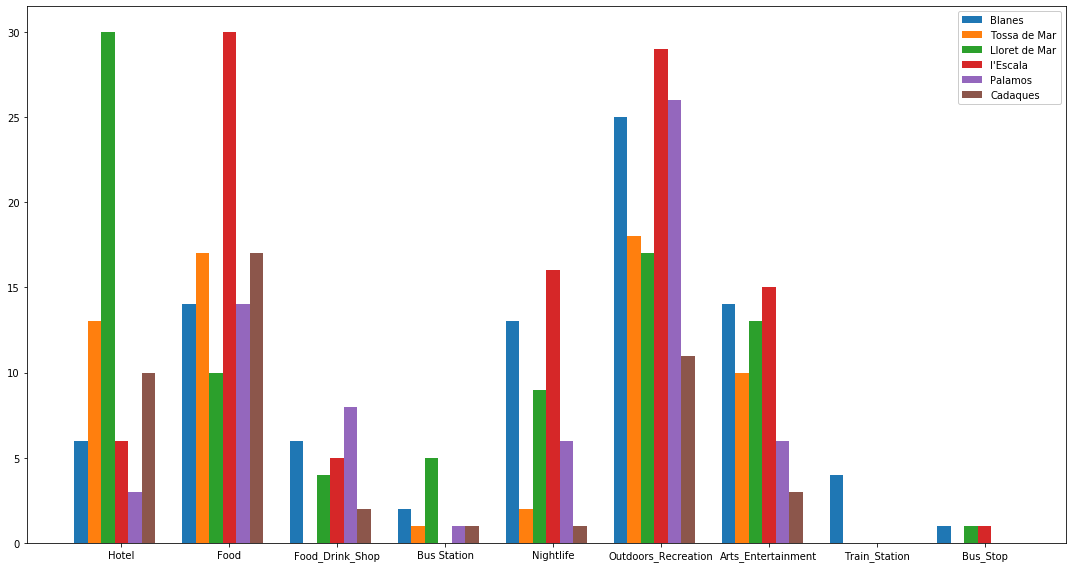

In [45]:
#plot bar for all these towns and main categories
listOfcount = np.array(datafr.values.T.tolist())
x = np.arange(listOfcount.shape[0])
dx = (np.arange(listOfcount.shape[1])-listOfcount.shape[1]/2.)/(listOfcount.shape[1]+2.)
d = 1./(listOfcount.shape[1]+2.)


fig, ax=plt.subplots(figsize=(15,8))
for i in range(listOfcount.shape[1]):
    ax.bar(x+dx[i],listOfcount[:,i], width=d, label=cit[i])

plt.xticks(x, categ)
fig.tight_layout()    
plt.legend(framealpha=4)
plt.show()

As we can see, such categories as Food, Hotel, Outdoors Recreation, Art Entertainments, and Nightlife are in all towns that we choosed earlier.

In **Tossa de Mar** we did not find any food and drink shops. 

In **l'Esala** there is no Bus Station.

Train Stations are only in **Blanes**. 

In **Tossa de Mar**, **Palamos**, and **Cadaques** there are no bus stops, in the other towns there are the same amount of bus stops. 

The biggest number of hotels is in **Lloret de Mar**.

The biggest number of Food places is in **l'Esala**.

The biggest number of Food and Drink shops is **Blanes** and **Palamos**.

The biggest number of Night life is in **Blanes** and **l'Esala**.

The biggest number of Outdoors and Recreation is in **Blanes**, **l'Esala**, and **Palamos**.

The biggest number of Art Entertainment is in **Blanes**, **Lloret**, and **l'Esala**.



The last step in our analysis is to explore separatly each city with all categories. And then do last compares and make decisions. 

First, let's explore ***Blanes***.

In [46]:
pd.DataFrame(data.loc[data['city'] == cit[0]]['main_category'].value_counts()).rename(columns={"main_category": cit[0]})

,Blanes
Outdoors_Recreation,25
Arts_Entertainment,14
Food,14
Nightlife,13
Food_Drink_Shop,6
Hotel,6
Train_Station,4
Bus Station,2
Bus_Stop,1


Get all names of categories of vanues that are in Blanes.

In [47]:
data.loc[data['city'] == cit[0]].categories.unique()

array(['Resort', 'Hotel', 'Vacation Rental', 'American Restaurant',
       'Coffee Shop', 'Asian Restaurant', 'Pizza Place', 'Restaurant',
       'Falafel Restaurant', 'Mediterranean Restaurant',
       'Italian Restaurant', 'Fast Food Restaurant', 'Sandwich Place',
       'Miscellaneous Shop', 'Supermarket', 'Food & Drink Shop',
       'Bus Stop', 'Bus Station', 'Train Station', 'Platform', 'Pub',
       'Cultural Center', 'Nightclub', 'Bar', 'Hotel Bar', 'Brewery',
       'Cocktail Bar', 'Nightlife Spot', 'Harbor / Marina', 'Beach',
       'Playground', 'Scenic Lookout', 'Other Great Outdoors', 'Park',
       'Cemetery', 'Neighborhood', 'Garden', 'Gym Pool',
       'Martial Arts Dojo', 'Campground', 'Surf Spot', 'Stadium',
       'Theme Park', 'Historic Site', 'Theater', 'General Entertainment',
       'Casino', 'Soccer Stadium', 'Racetrack', 'Multiplex',
       'Bowling Alley', 'Water Park'], dtype=object)

Plot barh of these categories. 

And we can say, that Blanes has a lot of different venues, activities. But, in this town there are the most supermarkets, beaches, hotels, restaurants, night clubs and other entertainments. So this city will be suitable for people who love active rest, night life. It can be good for friends and couples. Also for family with children, because there are some playgrounds. 

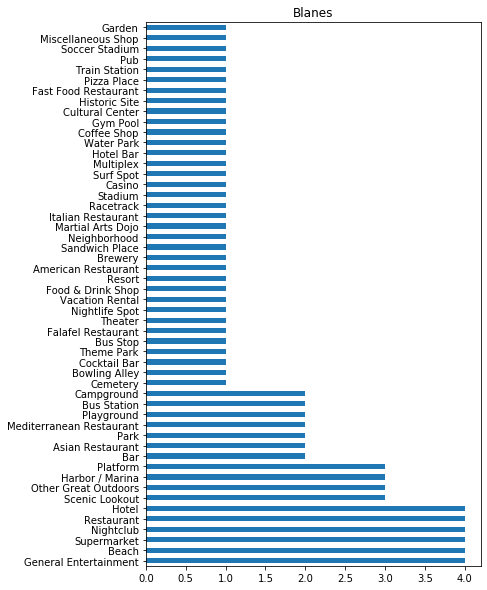

In [48]:
data.loc[data['city'] == cit[0]]['categories'].value_counts().plot(kind='barh', figsize=(6,10), title = cit[0], fontsize= 10)

Next town will be Tossa de Mar.

We can see, that here nightlife and entertainment are not so developed. 

In [49]:
pd.DataFrame(data.loc[data['city'] == cit[1]]['main_category'].value_counts()).rename(columns={"main_category": cit[1]})

,Tossa de Mar
Outdoors_Recreation,18
Food,17
Hotel,13
Arts_Entertainment,10
Nightlife,2
Bus Station,1


In [50]:
data.loc[data['city'] == cit[1]].categories.unique()

array(['Hotel', 'Motel', 'Resort', 'Bed & Breakfast', 'Tapas Restaurant',
       'Deli / Bodega', 'Spanish Restaurant', 'Mediterranean Restaurant',
       'Restaurant', 'Café', 'Breakfast Spot', 'Bus Station',
       'Sports Bar', 'Lounge', 'Town', 'Castle', 'Beach', 'Plaza',
       'Skate Park', 'Volleyball Court', 'Athletics & Sports', 'Cemetery',
       'Pool', 'Scenic Lookout', 'Lighthouse', 'Gym Pool',
       'History Museum', 'Movie Theater', 'Historic Site',
       'General Entertainment', 'Street Art', 'Concert Hall',
       'Art Gallery'], dtype=object)

Tossa de Mar has enough hotels, Mediterian restaurants and beaches. 

Here is Castle, Historic Site, Museums. 

This town is suitable for calm and quite rest. For people who don't love nightlife, noisy places and want to relax and be with nature. It is good for couples or old-aged people.   

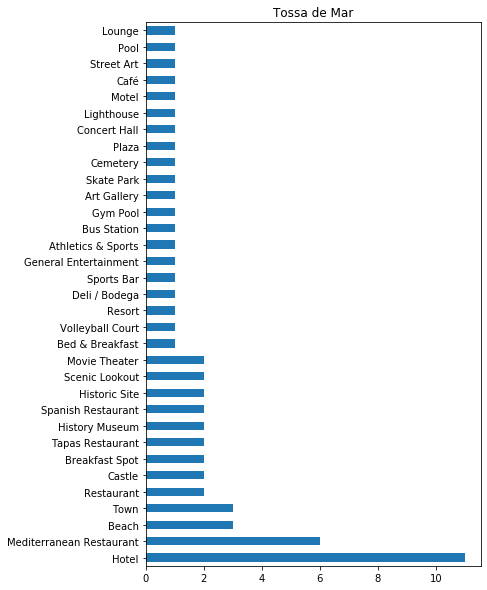

In [51]:
data.loc[data['city'] == cit[1]]['categories'].value_counts().plot(kind='barh', figsize=(6,10), title = cit[1], fontsize= 10)

Lloret de Mar has big choice of hotels and accomodations and all necessary facilities for comfortable rest.

In [52]:
pd.DataFrame(data.loc[data['city'] == cit[2]]['main_category'].value_counts()).rename(columns={"main_category": cit[2]})

,Lloret de Mar
Hotel,30
Outdoors_Recreation,17
Arts_Entertainment,13
Food,10
Nightlife,9
Bus Station,5
Food_Drink_Shop,4
Bus_Stop,1


In [53]:
data.loc[data['city'] == cit[2]].categories.unique()

array(['Hotel', 'Resort', 'Restaurant', 'Breakfast Spot',
       'Food & Drink Shop', 'Bistro', 'Spanish Restaurant',
       'Mediterranean Restaurant', 'Fast Food Restaurant', 'Café',
       'Supermarket', 'Bus Stop', 'Bus Station', 'Bus Line', 'Lounge',
       'Strip Club', 'Bar', 'Nightclub', 'Hotel Bar', 'Beach',
       'Scenic Lookout', 'Cemetery', 'Trail', 'Other Great Outdoors',
       'Pool', 'Gym / Fitness Center', 'Neighborhood', 'Historic Site',
       'Playground', 'Nudist Beach', 'General Entertainment',
       'Track Stadium', 'Soccer Stadium', 'Casino', 'Racetrack',
       'Theater', 'Roller Rink', 'History Museum', 'Bowling Alley',
       'Hockey Arena'], dtype=object)

Except hotels there are shops, beaches, restaurants, neighborhoods, museum, bus station and stop. So it is also suitable for active vacation, for families and friends.  

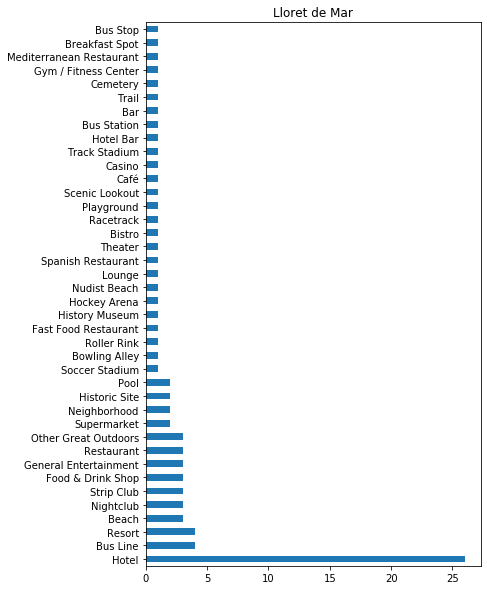

In [54]:
data.loc[data['city'] == cit[2]]['categories'].value_counts().plot(kind='barh', figsize=(6,10), title = cit[2], fontsize= 10)

In l'Escala we can find veriety of food places and outdoors&recreations.  There is not so bif of choice of hotels.

In [55]:
pd.DataFrame(data.loc[data['city'] == cit[3]]['main_category'].value_counts()).rename(columns={"main_category": cit[3]})

,l'Escala
Food,30
Outdoors_Recreation,29
Nightlife,16
Arts_Entertainment,15
Hotel,6
Food_Drink_Shop,5
Bus_Stop,1


In [56]:
data.loc[data['city'] == cit[3]].categories.unique()

array(['Hotel', 'Resort', 'Boarding House', 'Vacation Rental', 'Diner',
       'Bakery', 'Indian Restaurant', 'Spanish Restaurant', 'Bistro',
       'Seafood Restaurant', 'Turkish Restaurant', 'Hot Dog Joint',
       'Mediterranean Restaurant', 'Café', 'Restaurant',
       'Tapas Restaurant', 'Ice Cream Shop', 'Pizza Place', 'Brewery',
       'Gastropub', 'Italian Restaurant', 'Belgian Restaurant',
       'Paella Restaurant', 'Gourmet Shop', 'Farmers Market',
       'Supermarket', 'Wine Shop', 'Bus Stop', 'Nightclub', 'Sports Bar',
       'Other Nightlife', 'Bar', 'Beer Garden', 'Cocktail Bar', 'Town',
       'Beach', 'Harbor / Marina', 'Plaza', 'Trail', 'Scenic Lookout',
       'Soccer Field', 'Other Great Outdoors', 'Outdoors & Recreation',
       'Campground', 'Boat or Ferry', 'Lake', 'Gun Range', 'Neighborhood',
       'Pool', 'Sculpture Garden', 'Playground',
       'States & Municipalities', 'Piano Bar', 'Public Art',
       'Performing Arts Venue', 'Music Venue', 'Racetrack', 'R

There are a lot of bars, restaurants, beaches, cafes, historic sites. So we can say, that l'Escala is gastronomic town, and we can find what to do there. I guess, it will be good for young people, for teams, friends.  

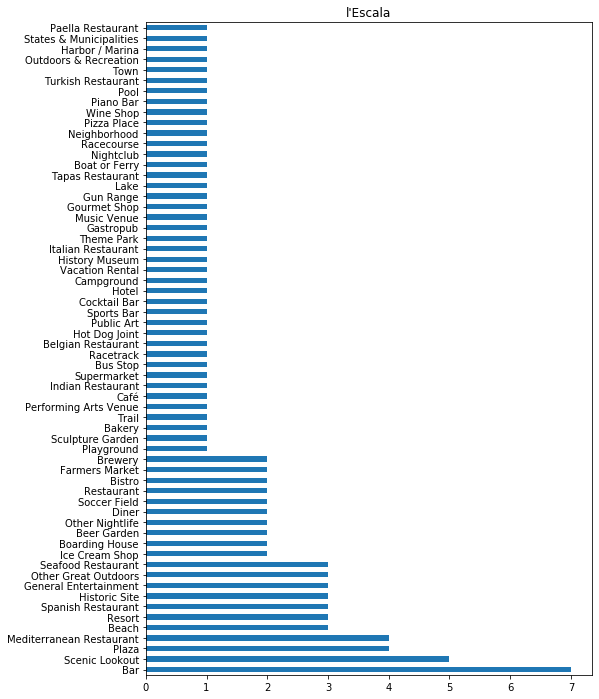

In [57]:
data.loc[data['city'] == cit[3]]['categories'].value_counts().plot(kind='barh', figsize=(8,12), title = cit[3], fontsize= 10)

Palamos is reach by veriety of outdoors and recreations. There are not a lot of hotels and night life. 

In [58]:
pd.DataFrame(data.loc[data['city'] == cit[4]]['main_category'].value_counts()).rename(columns={"main_category": cit[4]})

,Palamos
Outdoors_Recreation,26
Food,14
Food_Drink_Shop,8
Arts_Entertainment,6
Nightlife,6
Hotel,3
Bus Station,1


In [59]:
data.loc[data['city'] == cit[4]].categories.unique()

array(['Resort', 'Hotel', 'Café', 'Dessert Shop', 'Diner',
       'Thai Restaurant', 'Cafeteria', 'Tapas Restaurant',
       'Mediterranean Restaurant', 'Restaurant', 'Bakery', 'Snack Place',
       'Seafood Restaurant', 'Butcher', 'Fish Market',
       'Food & Drink Shop', 'Farmers Market', 'Supermarket',
       'Bus Station', 'Dive Bar', 'Strip Club', 'Arcade', 'Bar',
       'Speakeasy', 'Town', 'Park', 'Harbor / Marina', 'Village',
       'Gym / Fitness Center', 'Pool', 'Beach', 'Plaza', 'Playground',
       'Skate Park', 'Athletics & Sports', 'Soccer Field',
       'Other Great Outdoors', 'Campground', 'Trail', 'Lighthouse',
       'Music Venue', 'Movie Theater', 'Historic Site',
       'General Entertainment'], dtype=object)

In this town are harbours, beaches, different shops, cafes, restaurants, playgrounds. So, such town is suitable foe families with children and for old-aged people. 

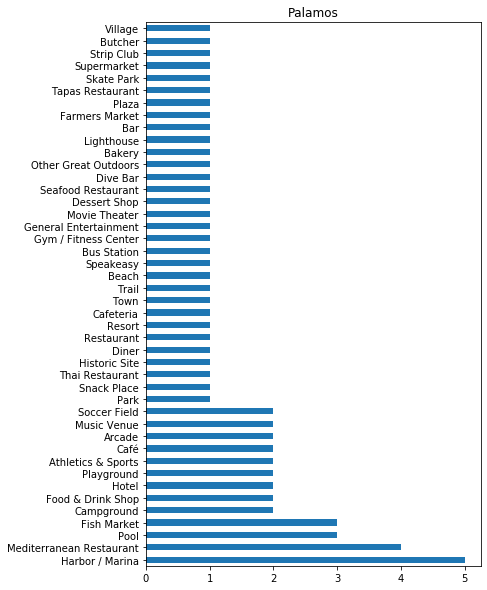

In [60]:
data.loc[data['city'] == cit[4]]['categories'].value_counts().plot(kind='barh',figsize=(6,10), title = cit[4], fontsize= 10)

Cadaques has not a lot of venues, no nightlife. Only some food places, hotels and outdoors&recreations. And, we can ,make a conclusion, that it is for calm rest. 

In [61]:
pd.DataFrame(data.loc[data['city'] == cit[5]]['main_category'].value_counts()).rename(columns={"main_category": cit[5]})

,Cadaques
Food,17
Outdoors_Recreation,11
Hotel,10
Arts_Entertainment,3
Food_Drink_Shop,2
Nightlife,1
Bus Station,1


In [62]:
data.loc[data['city'] == cit[5]].categories.unique()

array(['Hostel', 'Resort', 'Hotel', 'Vacation Rental', 'Tapas Restaurant',
       'Coffee Shop', 'Spanish Restaurant', 'Ice Cream Shop',
       'Deli / Bodega', 'Mediterranean Restaurant', 'Restaurant',
       'Italian Restaurant', 'Bar', 'French Restaurant', 'Breakfast Spot',
       'Asian Restaurant', 'Food & Drink Shop', 'Gourmet Shop',
       'Bus Station', 'Town', 'Beach', 'Harbor / Marina', 'Soccer Field',
       'Campground', 'Field', 'Art Museum', 'History Museum', 'Jazz Club'],
      dtype=object)

Hotels, beaches, restaurants, some bars, museum.

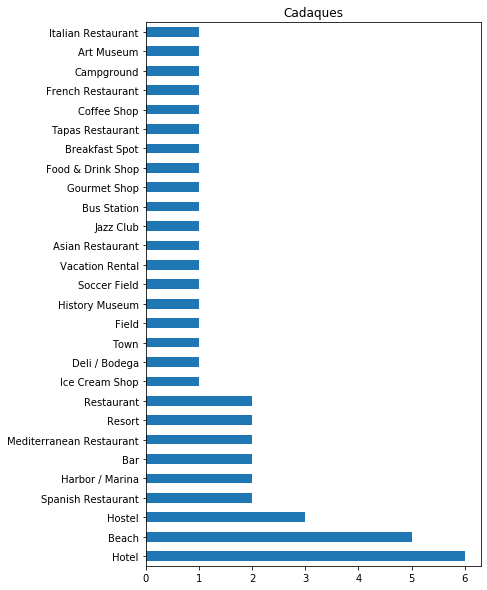

In [63]:
data.loc[data['city'] == cit[5]]['categories'].value_counts().plot(kind='barh', figsize=(6,10), title = cit[5], fontsize= 10)

And now the last time we compare these towns by separate category.

First category is beach.

There are most beaches in Cadaques, Blanes and l'Escala.

In [64]:
pd.DataFrame(data.loc[data['categories'] == 'Beach']['city'].value_counts()).rename(columns={"city": 'Beach'})

,Beach
Cadaques,5
Blanes,4
Tossa de Mar,3
Tamariu,3
l'Escala,3
Lloret de Mar,3
Llafranc,2
Palamos,1
Begur,1


Now will be hotels. 

As we know, it is Lloret de Mar.

In [65]:
pd.DataFrame(data.loc[data['categories'] == 'Hotel']['city'].value_counts()).rename(columns={"city": 'Hotel'})

,Hotel
Lloret de Mar,26
Tossa de Mar,11
Begur,10
Cadaques,6
Llafranc,5
Blanes,4
Palamos,2
Calella de Palafrugell,2
l'Escala,1
Pals,1


There are Restaurants in l'Escala, Blanes and Tossa de Mar

In [66]:
pd.DataFrame(data.loc[data['categories'].str.contains("Restaurant")]['city'].value_counts()).rename(columns={"city": 'Restaurant'})

,Restaurant
l'Escala,18
Tossa de Mar,12
Blanes,12
Begur,10
Cadaques,10
Palamos,8
Lloret de Mar,6
Llafranc,3
Calella de Palafrugell,3
Pals,2


There are Nightlife in l'Escala and Blanes. And no night life in Begur, Tossa de Mar, Pals, and Cadaques.   

In [67]:
pd.DataFrame(data.loc[data['main_category'] == 'Nightlife']['city'].value_counts()).rename(columns={"city": 'Nightlife'})

,Nightlife
l'Escala,16
Blanes,13
Lloret de Mar,9
Palamos,6
Tossa de Mar,2
Begur,2
Pals,1
Cadaques,1


There are More Playgrounds in Palamos and Blanes.

In [68]:
pd.DataFrame(data.loc[data['categories'] == 'Playground']['city'].value_counts()).rename(columns={"city": 'Playground'})

,Playground
Palamos,2
Blanes,2
Lloret de Mar,1
l'Escala,1
Llafranc,1


There are Shops in Palamos, Blanes, l'Escala, and Lloret de Mar.

In [69]:
pd.DataFrame(data.loc[data['main_category'] == 'Food_Drink_Shop']['city'].value_counts()).rename(columns={"city": 'Food_Drink_Shop'})

,Food_Drink_Shop
Palamos,8
Blanes,6
l'Escala,5
Lloret de Mar,4
Cadaques,2
Calella de Palafrugell,2
Pals,1
Tamariu,1


This is the end of analysis and exploration of sea cities of Spain, and now we are ready to get results togather and make conclusions

## Results and Discussion <a name="results"></a>

Our analysis shows, that in the Costa Brava sea side there are towns, for different kind of people. And anyone can find something interesting and suitable. So, I've chosen such groups of people: family with children, couples, aged people, friends, people who want calm vacation or vice versa. I investigated which city is the most suitable for each group.

We have seen, that some towns has more hotels, some has more nightlife, some has more restaurants etc. 

So, here my observations, that I have seen:

 1. Family with children - Blanes, Palamos, Llore de Mar
 
 2. Couples - Tossa de Mar, Blanes
 
 3. Aged people - Palamos, Tossa de Mar
 
 4. Friends - l'Escala, Blanes, Lloret de Mar
 
 5. People who want calm vacation - Cadaques, Tossa de Mar, 
 
 6. People who love active rest - Blanes, Lloret de Mar


## Conclusion <a name="conclusion"></a>

Purpose of this project was to identify sea cities o Spain, cluster them and specify which city is suitable for some groups of people. The problem was that there are a lot of websites and videos with information about these towns, but often it is only general description without information about accommodation, stores, beaches and other facilities. And there is a problem to choose the most appropriate town, that can satisfy our needs and possibilities. First step was to get data about venues for chosen towns using Foursquare api. Next step was data cleaning and filtering, where we get only data that we need for further analysss. After that, we made k-means clustering and specify that Begur and Pals are not located near the sea. Tamariu and Calella de Palafrugell have only small amount of venues, so such cities we left and explore only others. We compared all left seven towns and made some observation. 

I can underline my top towns, that are leaders in most categories and could be suitable for a lot of groups of people. So they are: 

1. Blanes

2. Lloret de Mar

3. Tossa de Mar. 


